# Test API

To test the API submission process

In [28]:
import traceback
import numpy as np
import pandas as pd
#import datatable as dt
import gc
import time
import os
import xgboost as xgb
import talib as ta
from script.crypto_API import *

## Model Version

In [29]:
ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

version = 34

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

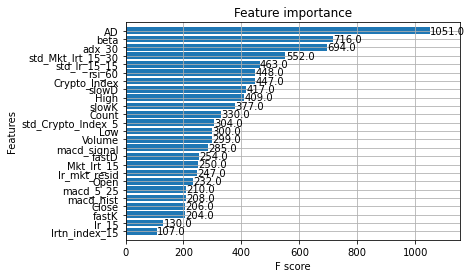

In [30]:
from os.path import exists
def model_reload_train(param_version):
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        model_file = f"./trainedXGB/model_nof_{param_version}/model_{asset_id}.json"
        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

models = model_reload_train(param_version=version)
xgb.plot_importance(models[1],height=0.8)

## get_features

In [31]:
# lrtn,fastk1,fastk2,adx,macd_s,macd_l,rsi,std_Crypto_Index,std_lr_15,std_Mkt_lrt_15 = \
#     (30, 5, 15, 30, 15, 25, 60, 15, 15, 5)
psets31 = dict(zip(['lrtn','fastk1','fastk2','adx','macd_s','macd_l','rsi','std_Crypto_Index','std_lr_15','std_Mkt_lrt_15'],
                   [30, 5, 15, 30, 15, 25, 60, 15, 15, 5]))
psets32 = dict(zip(['lrtn','fastk1','fastk2','adx','macd_s','macd_l','rsi','std_Crypto_Index','std_lr_15','std_Mkt_lrt_15'],
                   [30, 15, 15, 30, 10, 25, 60, 30, 15, 15]))
psets33 = dict(zip(['lrtn','fastk1','fastk2','adx','macd_s','macd_l','rsi','std_Crypto_Index','std_lr_15','std_Mkt_lrt_15'],
                   [15, 15, 5, 30, 5, 25, 60, 5, 15, 30]))
psets34 = dict(zip(['lrtn','fastk1','fastk2','adx','macd_s','macd_l','rsi','std_Crypto_Index','std_lr_15','std_Mkt_lrt_15'],
                   [15, 15, 5, 30, 5, 25, 60, 5, 15, 30]))


psets = dict(zip(sorted([int(s.split('_')[-1]) for s in os.listdir('./trainedXGB/') if 'model_nof' in s])[-2:],
                 [psets33,psets34]))

def log_return(series, periods=5):
    return np.log(series).diff(periods)


def lag_features(df, fastk1,fastk2,adx,macd_s,macd_l,rsi,std_Crypto_Index,std_lr_15,std_Mkt_lrt_15, **kwargs):    
    ####TECH indicators
    df['slowK'], df['slowD'] = ta.STOCH(df.High, df.Low, df.Close, 
                                        fastk_period=fastk1, slowk_period=int(3*fastk1/5), slowd_period=int(3*fastk1/5),
                                        slowk_matype=0, slowd_matype=0)
    df['fastK'], df['fastD'] = ta.STOCHF(df.High, df.Low, df.Close,
                                         fastk_period=fastk2, fastd_period=int(3*fastk2/5), 
                                         fastd_matype=0)
    df[f'rsi_{rsi}'] = ta.RSI(df['Close'], timeperiod=rsi)
    df[f'macd_{macd_s}_{macd_l}'],df['macd_signal'], df['macd_hist'] = \
                ta.MACD(df['Close'],fastperiod=macd_s, slowperiod=macd_l, signalperiod=5)
    df[f'adx_{adx}'] = ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=adx)#Average Directional Movement Index
    df['AD'] = ta.AD(df['High'], df['Low'],df['Close'], df['Volume'])#Accumulation Distribution Line
    ####std volatility
    df[f'std_lr_15_{std_lr_15}'] = ta.STDDEV(df.lr_15,timeperiod=std_lr_15, nbdev=1)
    df[f'std_Mkt_lrt_15_{std_Mkt_lrt_15}'] = ta.STDDEV(df.Mkt_lrt_15,timeperiod=std_Mkt_lrt_15, nbdev=1)
    df[f'std_Crypto_Index_{std_Crypto_Index}'] = ta.STDDEV(df.Crypto_Index,timeperiod=std_Crypto_Index, nbdev=1)

def beta(df, window=60): 
    b = (ta.MULT(df.Mkt_lrt_15,df.lr_15).rolling(window).mean())/(ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).rolling(window).mean())
    b = b.replace([np.nan,np.inf,-np.inf], 0)
    return b

def lr_mkt_resid(df):
    return ta.SUB(df.lr_15, ta.MULT(df.beta, df.Mkt_lrt_15))

def get_features(df_feat, psets):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat['beta'] = beta(df_feat)
    df_feat['lr_mkt_resid'] = lr_mkt_resid(df_feat)
        
    df_feat[f"lrtn_index_{psets['lrtn']}"] = log_return(df_feat.Crypto_Index, psets['lrtn'])
    lag_features(df_feat, **psets)
    return df_feat

## API submission

In [32]:
start = datestring_to_timestamp('2021-06-13T00:00:00')#2021-11-05T07:18:57
#end = datestring_to_timestamp('2021-09-21T00:00:00')
end = datestring_to_timestamp('2021-06-13T01:00:00')
train_df = read_csv_slice(file_path='./data/train.csv', 
                          use_window=[start, end])

In [33]:
######################################################
pre_minute=65
add_weight_map = dict(zip(df_asset_details.Asset_ID, 
                        df_asset_details.Weight/df_asset_details.Weight.sum()))

###load sup_train
sup_train = pd.read_csv('./data/supplemental_train.csv')
sup_train = sup_train.sort_values('timestamp').set_index("timestamp")
ind = sup_train.index.unique()
###consistent timestamp for all 14 assets
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
sup_train = sup_train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
sup_train = sup_train.iloc[(-14*pre_minute):,:]
#clean VWAP
sup_train.replace(to_replace=[np.inf, -np.inf],value= np.nan, inplace=True)
sup_train['VWAP']=sup_train['VWAP'].fillna((sup_train['High']+sup_train['Low'])/2)
#add weight
sup_train['Weight'] = sup_train['Asset_ID'].map(add_weight_map)
sup_train.drop('Target',axis=1, inplace=True)
sup_train.set_index('Asset_ID',append=True, inplace=True)
#######################################add lr_15,mkt_lr_15,crypto_index, beta,lr_mkt_resid
lr_15 = sup_train.groupby('Asset_ID').apply( 
        lambda x: log_return(x[['Close']],15)
        )
sup_train['lr_15'] = lr_15['Close']

mkt_lr_15 = sup_train.groupby('timestamp').apply( 
    lambda x: x[["lr_15", "Close"]].multiply(x["Weight"], axis="index").sum()
    )
mkt_lr_15.columns = ['Mkt_lrt_15','Crypto_Index']
firsts = sup_train.index.get_level_values('timestamp')
sup_train[['Mkt_lrt_15','Crypto_Index']] = mkt_lr_15.loc[firsts].values

# ddd = sup_train.groupby("Asset_ID").apply(lambda x: beta(x)).rename("beta").to_frame().reset_index(0,drop=True)
# ddd = ddd.replace([np.nan,np.inf,-np.inf], 0)
# sup_train= sup_train.merge(ddd, on =['timestamp','Asset_ID'],how='left')
# sup_train['lr_mkt_resid'] = lr_mkt_resid(sup_train)

sup_train.iloc[-14:,]

Count          Open          High           Low  \
timestamp  Asset_ID                                                     
1641772800 6         2059.0   3151.504286   3152.150000   3143.790000   
           11          52.0    190.732000    191.160000    189.800000   
           10          20.0   2122.416667   2124.010000   2116.950000   
           9          218.0    130.842571    130.940000    130.478000   
           8           29.0      1.034633      1.075000      0.957800   
           7           75.0     29.731780     29.751000     29.698200   
           5           88.0      2.794480      2.800000      2.788562   
           4          197.0      0.150498      0.150600      0.150200   
           3          351.0      1.170103      1.170729      1.167000   
           2          106.0    376.696667    376.950000    376.000000   
           1         2111.0  41860.168571  41877.700000  41766.700000   
           0          288.0    438.722333    438.800000    437.700000   
           12         112.0      0.261055      0.261185      0.260474   
           13         118.0      0.066109      0.066130      0.066058   

                            Close        Volume          VWAP    Weight  \
timestamp  Asset_ID                                                       
1641772800 6          3147.158571  5.786272e+02   3148.128143  0.144188   
           11          190.506000  1.355932e+02    190.622811  0.039370   
           10         2119.743333  2.084755e+00   2120.570582  0.026874   
           9           130.707429  1.011042e+03    130.734076  0.058657   
           8             1.034400  8.585877e+03      1.034341  0.026874   
           7            29.715100  1.063943e+03     29.721728  0.050867   
           5             2.789640  2.411353e+04      2.792239  0.033911   
           4             0.150307  1.145598e+06      0.150394  0.086971   
           3             1.167863  1.692235e+05      1.168722  0.107797   
           2           376.480000  1.443180e+02    376.560393  0.058657   
           1         41823.085714  8.982209e+01  41830.240059  0.165850   
           0           437.990333  4.016819e+02    438.278705  0.105286   
           12            0.260682  1.187581e+05      0.260913  0.050867   
           13            0.066082  1.265238e+06      0.066086  0.043830   

                        lr_15  Mkt_lrt_15  Crypto_Index  
timestamp  Asset_ID                                      
1641772800 6        -0.003110   -0.003263   7532.261935  
           11       -0.000454   -0.003263   7532.261935  
           10       -0.003462   -0.003263   7532.261935  
           9        -0.004696   -0.003263   7532.261935  
           8        -0.001899   -0.003263   7532.261935  
           7        -0.003969   -0.003263   7532.261935  
           5        -0.005577   -0.003263   7532.261935  
           4        -0.003500   -0.003263   7532.261935  
           3        -0.005190   -0.003263   7532.261935  
           2        -0.002764   -0.003263   7532.261935  
           1        -0.002324   -0.003263   7532.261935  
           0        -0.002281   -0.003263   7532.261935  
           12       -0.003568   -0.003263   7532.261935  
           13       -0.003493   -0.003263   7532.261935

In [34]:
myapi = API(train_df)
from datetime import datetime 
start_time = datetime.now()

for df_test, df_pred in myapi:
    num_asset_test = df_test.shape[0]
    row_asset_id_map = dict(zip(df_test.row_id, df_test.Asset_ID))
    test_timestamp = df_test.timestamp.values[0]
    
    timestamp_list = sup_train.index.get_level_values('timestamp').unique().values
    timestamp_list = np.append(timestamp_list,test_timestamp)
    #######################################format df_test
    ###add weight and index
    df_test['Weight'] = df_test['Asset_ID'].map(add_weight_map)
    ###fillin missing assets as nan
    df_test.set_index(['timestamp','Asset_ID'],inplace=True)
    df_test = df_test.reindex(list(zip([test_timestamp]*14,range(14))))
    ########################################concat to sup_train, add lr_15,mkt_lr_15,crypto_index
    sup_train = pd.concat([sup_train,df_test.drop('row_id',axis=1)],join='outer')
    test_lr_15 = sup_train.loc[timestamp_list[[-16,-1]]].groupby('Asset_ID').apply(
        lambda x: np.log(x[['Close']]).diff()
    )
    sup_train.loc[test_timestamp, 'lr_15'] = test_lr_15.loc[test_timestamp,'Close'].values
    sup_train.loc[test_timestamp, ['Mkt_lrt_15','Crypto_Index']] = sup_train.loc[test_timestamp, ["lr_15", "Close"]].multiply(sup_train.loc[test_timestamp,"Weight"], axis="index").sum().values
    #########################################fill in missing assets as forward
    if num_asset_test <14:
        #ffill in missing
        sup_train = sup_train.groupby('Asset_ID').apply(lambda x: x.fillna(method="ffill")).iloc[14:,:]
    else:
        sup_train = sup_train.iloc[14:,:]
    
    #######################################add features to test timestamp
    sup_train2 = sup_train.copy()
    xx_test=sup_train2.groupby('Asset_ID').apply(
        lambda x: get_features(x,psets[version])
    ).loc[test_timestamp]
    
    #rdy for prediction
    y_pred=df_test.apply(lambda row: models[row.name[1]].predict(
                            xgb.DMatrix(pd.DataFrame([xx_test.loc[row.name[1],models[row.name[1]].feature_names]]))
                                                                )[-1]
                         ,axis =1)
    #match with row_id
    y_pred.reset_index('timestamp',drop=True,inplace=True)
    df_pred['Target']= y_pred.loc[df_pred['row_id'].map(row_asset_id_map)].values
    myapi.predict(df_pred)


time_elapsed = datetime.now() - start_time
print('Time elapsed total (hh:mm:ss.ms) {}'.format(time_elapsed))
print(f'time elapsed per iteration {time_elapsed/myapi.init_num_times}')
print(f'Submission time estimate {129600*time_elapsed/myapi.init_num_times}')


This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
Time elapsed total (hh:mm:ss.ms) 0:00:04.352299
time elapsed per iteration 0:00:00.072538
Submission time estimate 2:36:40.965840


In [35]:
##scoring
id_2_weight = dict(zip(df_asset_details.Asset_ID, df_asset_details.Weight))
df, score = myapi.score(id_2_weight)
print(f"Your LB score is {round(score, 4)}")

Your LB score is -0.1066


In [36]:
myapi.predictions

[            row_id    Target
 22221694  22221694 -0.001948
 22221695  22221695 -0.008364
 22221696  22221696  0.002257
 22221697  22221697 -0.000316
 22221698  22221698 -0.011889
 22221699  22221699 -0.001134
 22221700  22221700 -0.032022
 22221701  22221701  0.002597
 22221702  22221702  0.008204
 22221703  22221703 -0.001501
 22221704  22221704  0.001029
 22221705  22221705  0.087300
 22221706  22221706  4.676879
 22221707  22221707  0.021598,
             row_id    Target
 22221708  22221708 -0.002009
 22221709  22221709 -0.009080
 22221710  22221710  0.003043
 22221711  22221711 -0.000488
 22221712  22221712 -0.014272
 22221713  22221713 -0.000581
 22221714  22221714 -0.035341
 22221715  22221715  0.002070
 22221716  22221716  0.007922
 22221717  22221717 -0.001151
 22221718  22221718  0.001371
 22221719  22221719  0.002185
 22221720  22221720  4.612403
 22221721  22221721  0.037755,
             row_id    Target
 22221722  22221722 -0.002329
 22221723  22221723 -0.003915
 2222172